In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import Path
from fastai.vision import Image
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import re
import random

In [4]:
raw_dir = Path("/hpf/largeprojects/MICe/nwang/TissueVision/2019-05-31_Mallar_NeuralNet/raw")
raws = [raw_path for raw_path in raw_dir.ls() if ".tif" in raw_path.as_posix()]
images = sorted([raw_path for raw_path in raws if "_image" in raw_path.as_posix()])
labels = sorted([raw_path for raw_path in raws if "_label" in raw_path.as_posix()])

processed_dir = Path("/hpf/largeprojects/MICe/nwang/TissueVision/2019-05-31_Mallar_NeuralNet/processed")
l=224

In [4]:
random.seed(1)
cutoff=1
empty = 0
R_popu = 0
popu = 0

for image_path,label_path in zip(images,labels):
    image = cv.imread(image_path.as_posix(), cv.COLOR_BGR2GRAY)
#     image = cv.medianBlur(image, ksize = 3)
    label = cv.imread(label_path.as_posix(), cv.COLOR_BGR2GRAY)

    if image.shape != label.shape:
        raise ValueError()
    i_max = image.shape[0]//l
    j_max = image.shape[1]//l

#         If the cells were labelled as 255 instead of 1.
    label[label!=0]=1

    for i in range(i_max):
        for j in range(j_max):
            cropped_image = image[l*i:l*(i+1), l*j:l*(j+1)]
            cropped_label = label[l*i:l*(i+1), l*j:l*(j+1)]
            
            if ("_R_" in image_path.as_posix() and (cropped_label!=0).any()):
                R_popu+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + label_path.suffix)
            elif "_R_" in image_path.as_posix():
                continue
            elif (cropped_label!=0).any():
                popu+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + label_path.suffix)
            elif random.random() >= cutoff:
                empty+=1
                cropped_image_path = processed_dir/(image_path.stem + "_i" + str(i) + "_j" + str(j) + "_empty" + image_path.suffix)
                cropped_label_path = processed_dir/(label_path.stem + "_i" + str(i) + "_j" + str(j) + "_empty" + label_path.suffix)
            else:
                continue
            cv.imwrite(cropped_image_path.as_posix(), cropped_image)
            cv.imwrite(cropped_label_path.as_posix(), cropped_label)

In [5]:
print(R_popu)
print(popu)
print(empty)

NameError: name 'R_popu' is not defined

## Train NN

In [7]:
bs = 2 #bs=16 will use ~7300MiB for resnet34

In [8]:
transforms = get_transforms(
    do_flip = True,
    flip_vert = True,
    max_zoom = 1, #consider
    max_rotate = 45,
    max_lighting = None,
    max_warp = None,
    p_affine = 0.75,
    p_lighting = 0.75)

In [9]:
get_label_from_image = lambda path: re.sub(r'_image_', '_label_', path.as_posix())
codes = ["NOT-CELL", "CELL"]
def filter_empties(fname, cutoff=0.95):
    if "empty" in Path(fname).name:
        # Return the next random floating point number in the range [0.0, 1.0).
        return (random.random() > cutoff)
    else:
        return True

src = (
    SegmentationItemList.from_folder(processed_dir)
    .filter_by_func(lambda fname:'image' in Path(fname).name)
#     .filter_by_func(filter_empties)
    .split_by_rand_pct(valid_pct=0.20, seed=2)
    .label_from_func(get_label_from_image, classes=codes)
)
data = (
    src.transform(transforms)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [10]:
learn = unet_learner(data, models.resnet50, metrics=partial(dice, iou=True))
learn.loss_func = CrossEntropyFlat(axis=1, weight = torch.Tensor([0.04,1]).cuda())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


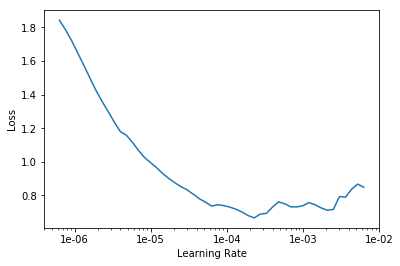

In [31]:
lr_find(learn)
learn.recorder.plot()

In [32]:
lr = 2e-4
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,dice,time
0,0.283856,0.143630,0.241704,01:16
1,0.249848,0.104195,0.248818,01:17
2,0.237653,0.335587,0.004833,01:17
3,0.234828,0.230321,0.020349,01:17
4,0.231632,0.104952,0.226719,01:18
5,0.230605,0.146206,0.130361,01:19
6,0.227980,0.143526,0.090570,01:17
7,0.222106,0.132164,0.284974,01:17
8,0.217920,0.205688,0.000000,01:17
9,0.218154,0.147661,0.027551,01:17


In [13]:
models_path = Path("/hpf/largeprojects/MICe/nwang/TissueVision/2019-05-31_Mallar_NeuralNet/models")
# learn.save(models_path/"2019-06-12_RESNET50_IOU0.42")
learn.load(models_path/"2019-06-12_RESNET50_IOU0.42", device = torch.device('cuda'))

Learner(data=ImageDataBunch;

Train: LabelList (92 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /hpf/largeprojects/MICe/nwang/TissueVision/2019-05-31_Mallar_NeuralNet/processed;

Valid: LabelList (23 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: /hpf/largeprojects/MICe/nwang/TissueVision/2019-05-31_Mallar_NeuralNet/processed;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    

In [40]:
learn.export(file = models_path/"2019-06-12_RESNET50_IOU0.42.pkl")

In [42]:
learn.purge()

this object has been destroyed


In [19]:
print(learn.data.valid_ds.__len__()) #list of N
print(learn.data.valid_ds[0]) #tuple of input image and segment
print(learn.data.valid_ds[0][1])
# print(learn.data.valid_ds.__len__())
# type(learn.data.valid_ds[0][0])

16
(Image (3, 224, 224), ImageSegment (1, 224, 224))
ImageSegment (1, 224, 224)


In [14]:
# preds = learn.get_preds(with_loss=True)
preds = learn.get_preds()

In [19]:
print(len(preds)) # tuple of list of probs and targets
print(preds[0].shape) #predictions
print(preds[0][0].shape) #probabilities for each label
print(learn.data.classes) #what is each label
print(preds[0][0][0].shape) #probabilities for label 0
# for i in range(0,N):
#     print(torch.max(preds[0][i][1]))

# Image(preds[1][0]).show()

2
torch.Size([23, 2, 224, 224])
torch.Size([2, 224, 224])
['NOT-CELL', 'CELL']
torch.Size([224, 224])


In [15]:
if learn.data.valid_ds.__len__() == preds[1].shape[0]:
    N = learn.data.valid_ds.__len__()
else:
    raise ValueError()

xs = [learn.data.valid_ds[i][0] for i in range(N)]
ys = [learn.data.valid_ds[i][1] for i in range(N)]
p0s = [Image(preds[0][i][0]) for i in range(N)]
p1s = [Image(preds[0][i][1]) for i in range(N)]
argmax = [Image(preds[0][i].argmax(dim=0)) for i in range(N)]

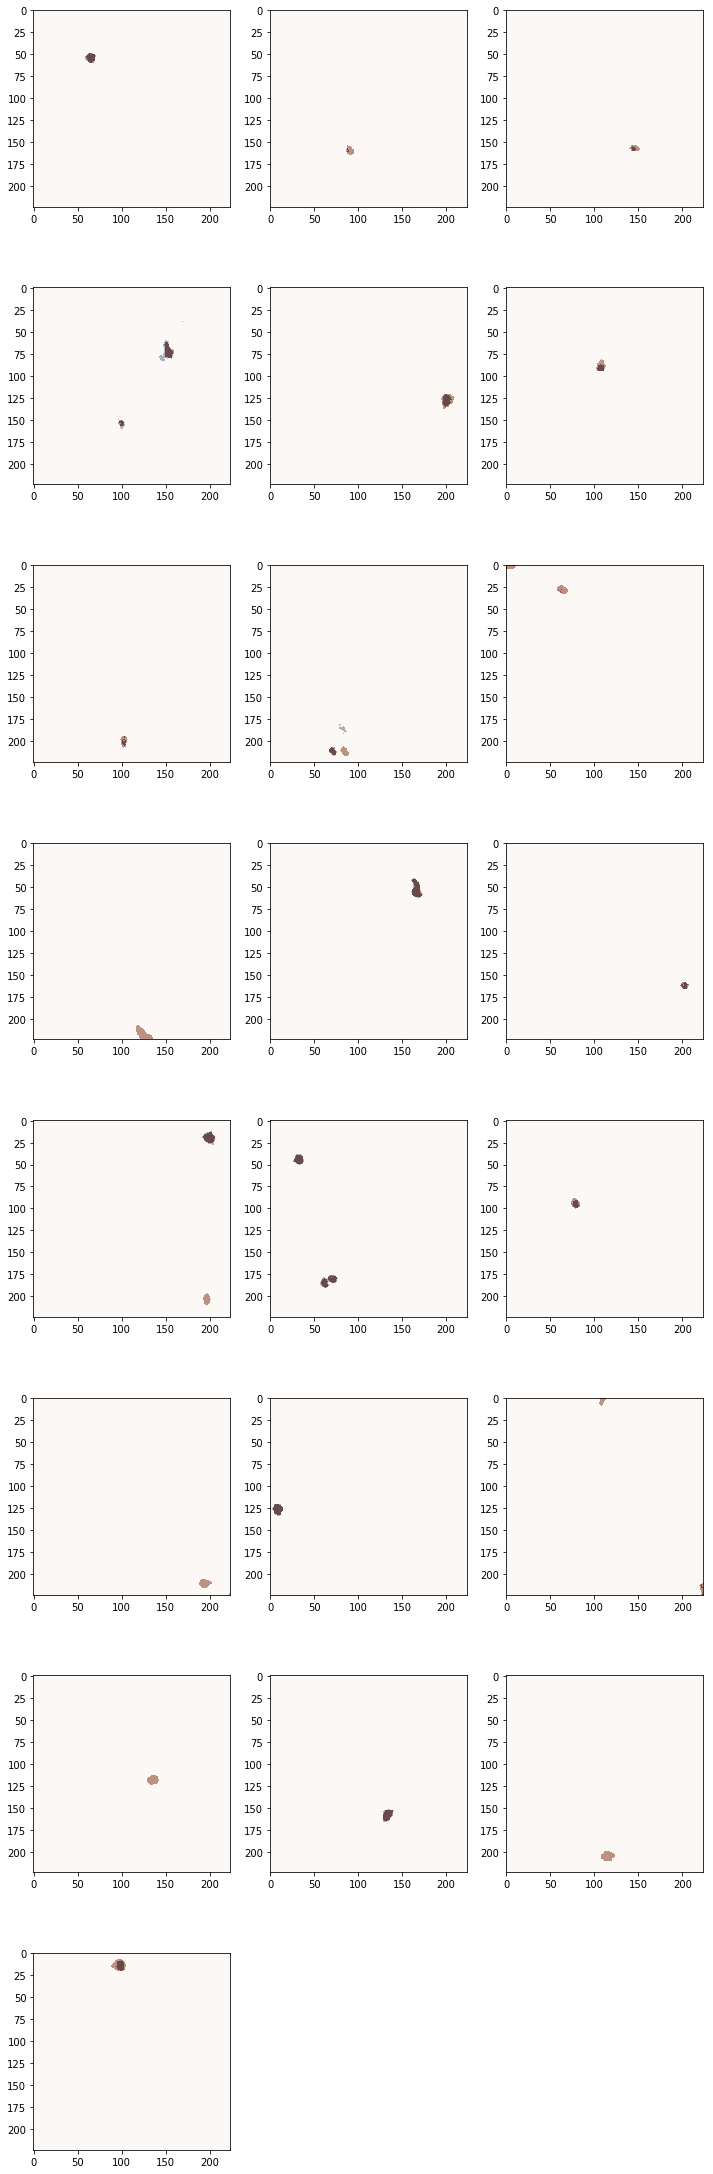

In [17]:
ncol = 3
nrow = N//ncol + 1
fig=plt.figure(figsize=(12, nrow*5))
for i in range(1,N):
    fig.add_subplot(nrow, ncol, i)
#     plt.imshow(xs[i-1].px.permute(1, 2, 0), cmap = "Oranges", alpha=0.5)
    plt.imshow(argmax[i-1].px, cmap = "Blues", alpha=0.7)
#     plt.imshow(p1s[i-1].px, cmap = "Blues", alpha=0.7)
    plt.imshow(ys[i-1].px[0], cmap = "Oranges", alpha=0.5)
plt.savefig('/hpf/largeprojects/MICe/nwang/TissueVision/2019-05-31_Mallar_NeuralNet/figures/2019-06-12_mallar-results.png')
plt.show()

In [25]:
learn.freeze_to(-2)

In [26]:
lrs = slice(lr/400,lr/4)

In [28]:
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,dice,time


RuntimeError: CUDA out of memory. Tried to allocate 49.00 MiB (GPU 0; 7.93 GiB total capacity; 6.96 GiB already allocated; 30.19 MiB free; 76.20 MiB cached)